In [2]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
#plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

In [3]:
from numpy.fft import fft2

In [89]:
filter_bank2D = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/data')
filter_bank2D_J_L = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/J_L')
filter_bank2D_psi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/psi_index')
filter_bank2D_phi_index = hd5_open('../scratch_AKS/data/filter_bank_paper_export.h5','main/phi_index')

Figure 1

In [49]:
import matplotlib.colors as mcolors
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
colors = [(0,1,0,c) for c in np.linspace(0,1,100)]
cmapgreen = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)

In [68]:
from scipy.ndimage import map_coordinates

In [170]:
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad

def drawCirc(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Line
    arc = Arc([centX,centY],radius,radius,angle=angle_,
          theta1=0,theta2=theta2_,color=color_) #capstyle='round',linestyle='-',lw=10
    ax.add_patch(arc)


    #========Create the arrow head
    endX=centX+(radius/2)*np.cos(rad(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(rad(theta2_+angle_))

    ax.add_patch(                    #Create triangle as arrow head
        RegularPolygon(
            (endX, endY),            # (x,y)
            3,                       # number of vertices
            radius/25,                # radius
            rad(angle_+theta2_),     # orientation
            color=color_
        )
    )
    #ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 
    # Make sure you keep the axes scaled or else arrow will distort

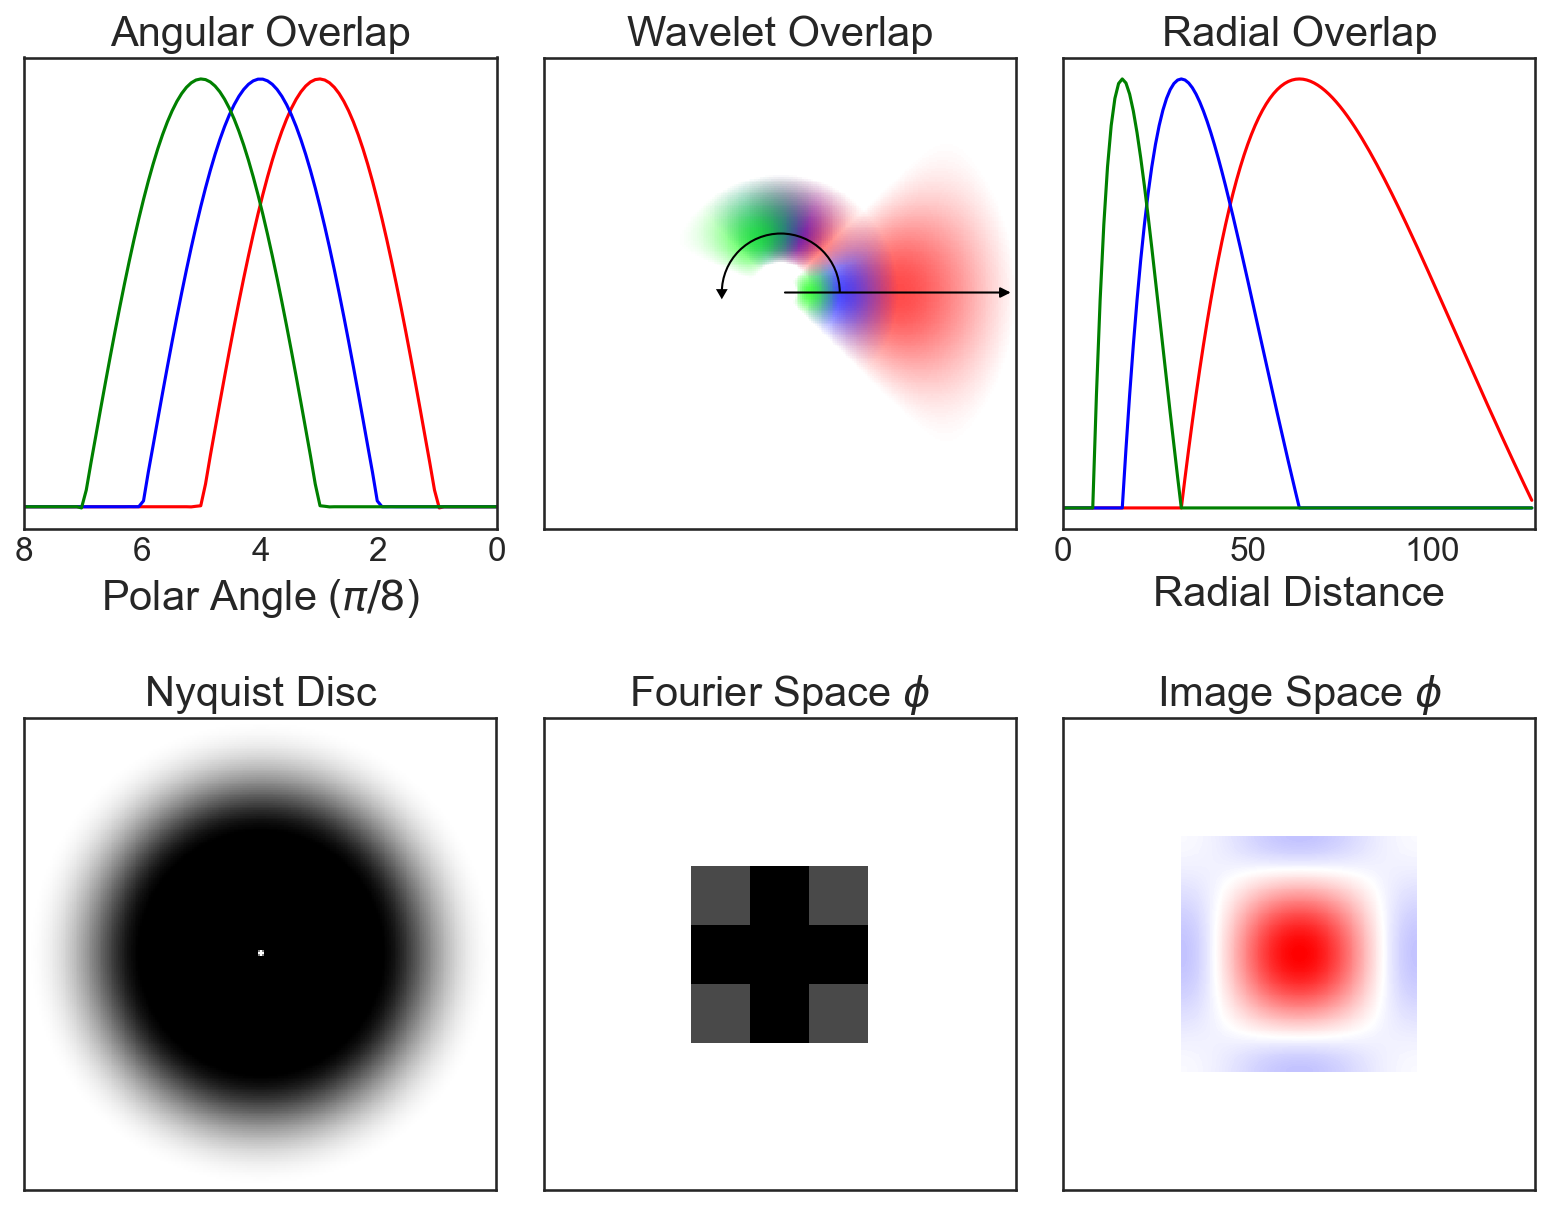

In [183]:
## Figure 1
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(13,10), dpi=150)
colormaps = [cmapred,cmapblue,cmapgreen]

ax = fig.add_subplot(2,3,2)
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[jind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
ax.axes.set_title('Wavelet Overlap')

ax.annotate("",
            xy=(255, 128), xycoords='data',
            xytext=(128, 128), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3",
                            color='k'),
            )

drawCirc(ax,64,128,128,0,180)

colormaps = [cmapred,cmapblue,cmapgreen]
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    ax.imshow(
        np.fft.fftshift(data).T,
        vmin=0,
        vmax=1,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[lind],
        aspect='equal',
        alpha=1
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,3)
color_opt = ['red','blue','green']
l=0
for jind, j in enumerate([0,1,2]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    plt.plot(np.fft.fftshift(data).T[128,128:],color=color_opt[jind])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlim(0,128)
ax.axes.set_xlabel('Radial Distance')
ax.axes.set_title('Radial Overlap')

ax = fig.add_subplot(2,3,1)
color_opt = ['red','blue','green']
j=1
for lind, l in enumerate([3,4,5]):
    data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
    data = np.fft.fftshift(data)
    
    t = np.linspace(np.pi,0,100)
    r = 32
    xc = 128
    yc = 128
    x = r*np.cos(t) + xc
    y = r*np.sin(t) + yc
    zi_fink = map_coordinates(data, np.vstack((x,y)))
    plt.plot(t/np.pi*8,zi_fink,color=color_opt[lind])
    ax.set_xlim(8, 0)
    ax.axes.yaxis.set_ticks([])
ax.axes.set_xlabel('Polar Angle ($\pi/8$)')
ax.axes.set_title('Angular Overlap')

ax = fig.add_subplot(2,3,4)
total_im_energy = np.zeros((256,256))
for j in range(6):
    for l in range(16):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1].T
        total_im_energy += np.fft.fftshift(data)**2

ax.imshow(
    total_im_energy,
    vmin=0,
    #vmax=1,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal',
    alpha=1
)
ax.axes.set_title('Nyquist Disc')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

ax = fig.add_subplot(2,3,5)

data = filter_bank2D[filter_bank2D_phi_index[0]-1].T
scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])

j=5
ax.imshow(
    np.fft.fftshift(data),
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.set_title('Fourier Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])

ax = fig.add_subplot(2,3,6)
ax.imshow(
    np.real(np.fft.fftshift(fft2(data)).T),
    vmin=-scale,
    vmax=scale,
    origin='lower',
    interpolation='nearest',
    cmap='bwr',
    aspect='equal'
)
ax.axes.set_title('Image Space $\phi$')
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])

fig.subplots_adjust(wspace=0.1, hspace=0.4)
plt.savefig('../figures/FinkletOrient.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 2

In [223]:
def subplotter(data,fig,subplotx,subploty,subplotindx,j):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    ax.imshow(
        np.fft.fftshift(data).T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(7-j),128+2**(7-j)])
    ax.axes.set_ylim([128-2**(7-j),128+2**(7-j)])
    ax.text(0.14, 0.05, 'FS j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    scale = np.max([np.abs(np.real(np.fft.fftshift(fft2(data)).T).max()),np.abs(np.real(np.fft.fftshift(fft2(data)).T).min())])
    ax = fig.add_subplot(subplotx,subploty,subplotindx+8)
    ax.imshow(
        np.real(np.fft.fftshift(fft2(data)).T),
        vmin=-scale,
        vmax=scale,
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Re j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)

    ax = fig.add_subplot(subplotx,subploty,subplotindx+16)
    ax.imshow(
        np.imag(np.fft.fftshift(fft2(data)).T),
        origin='lower',
        interpolation='nearest',
        cmap='bwr',
        aspect='equal'
    )
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.axes.set_xlim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.axes.set_ylim([128-2**(np.abs(j+3)),128+2**(np.abs(j+3))])
    ax.text(0.14, 0.05, 'Im j={} $\ell$={}'.format(j+1,l), transform=ax.transAxes, size=12)
    return

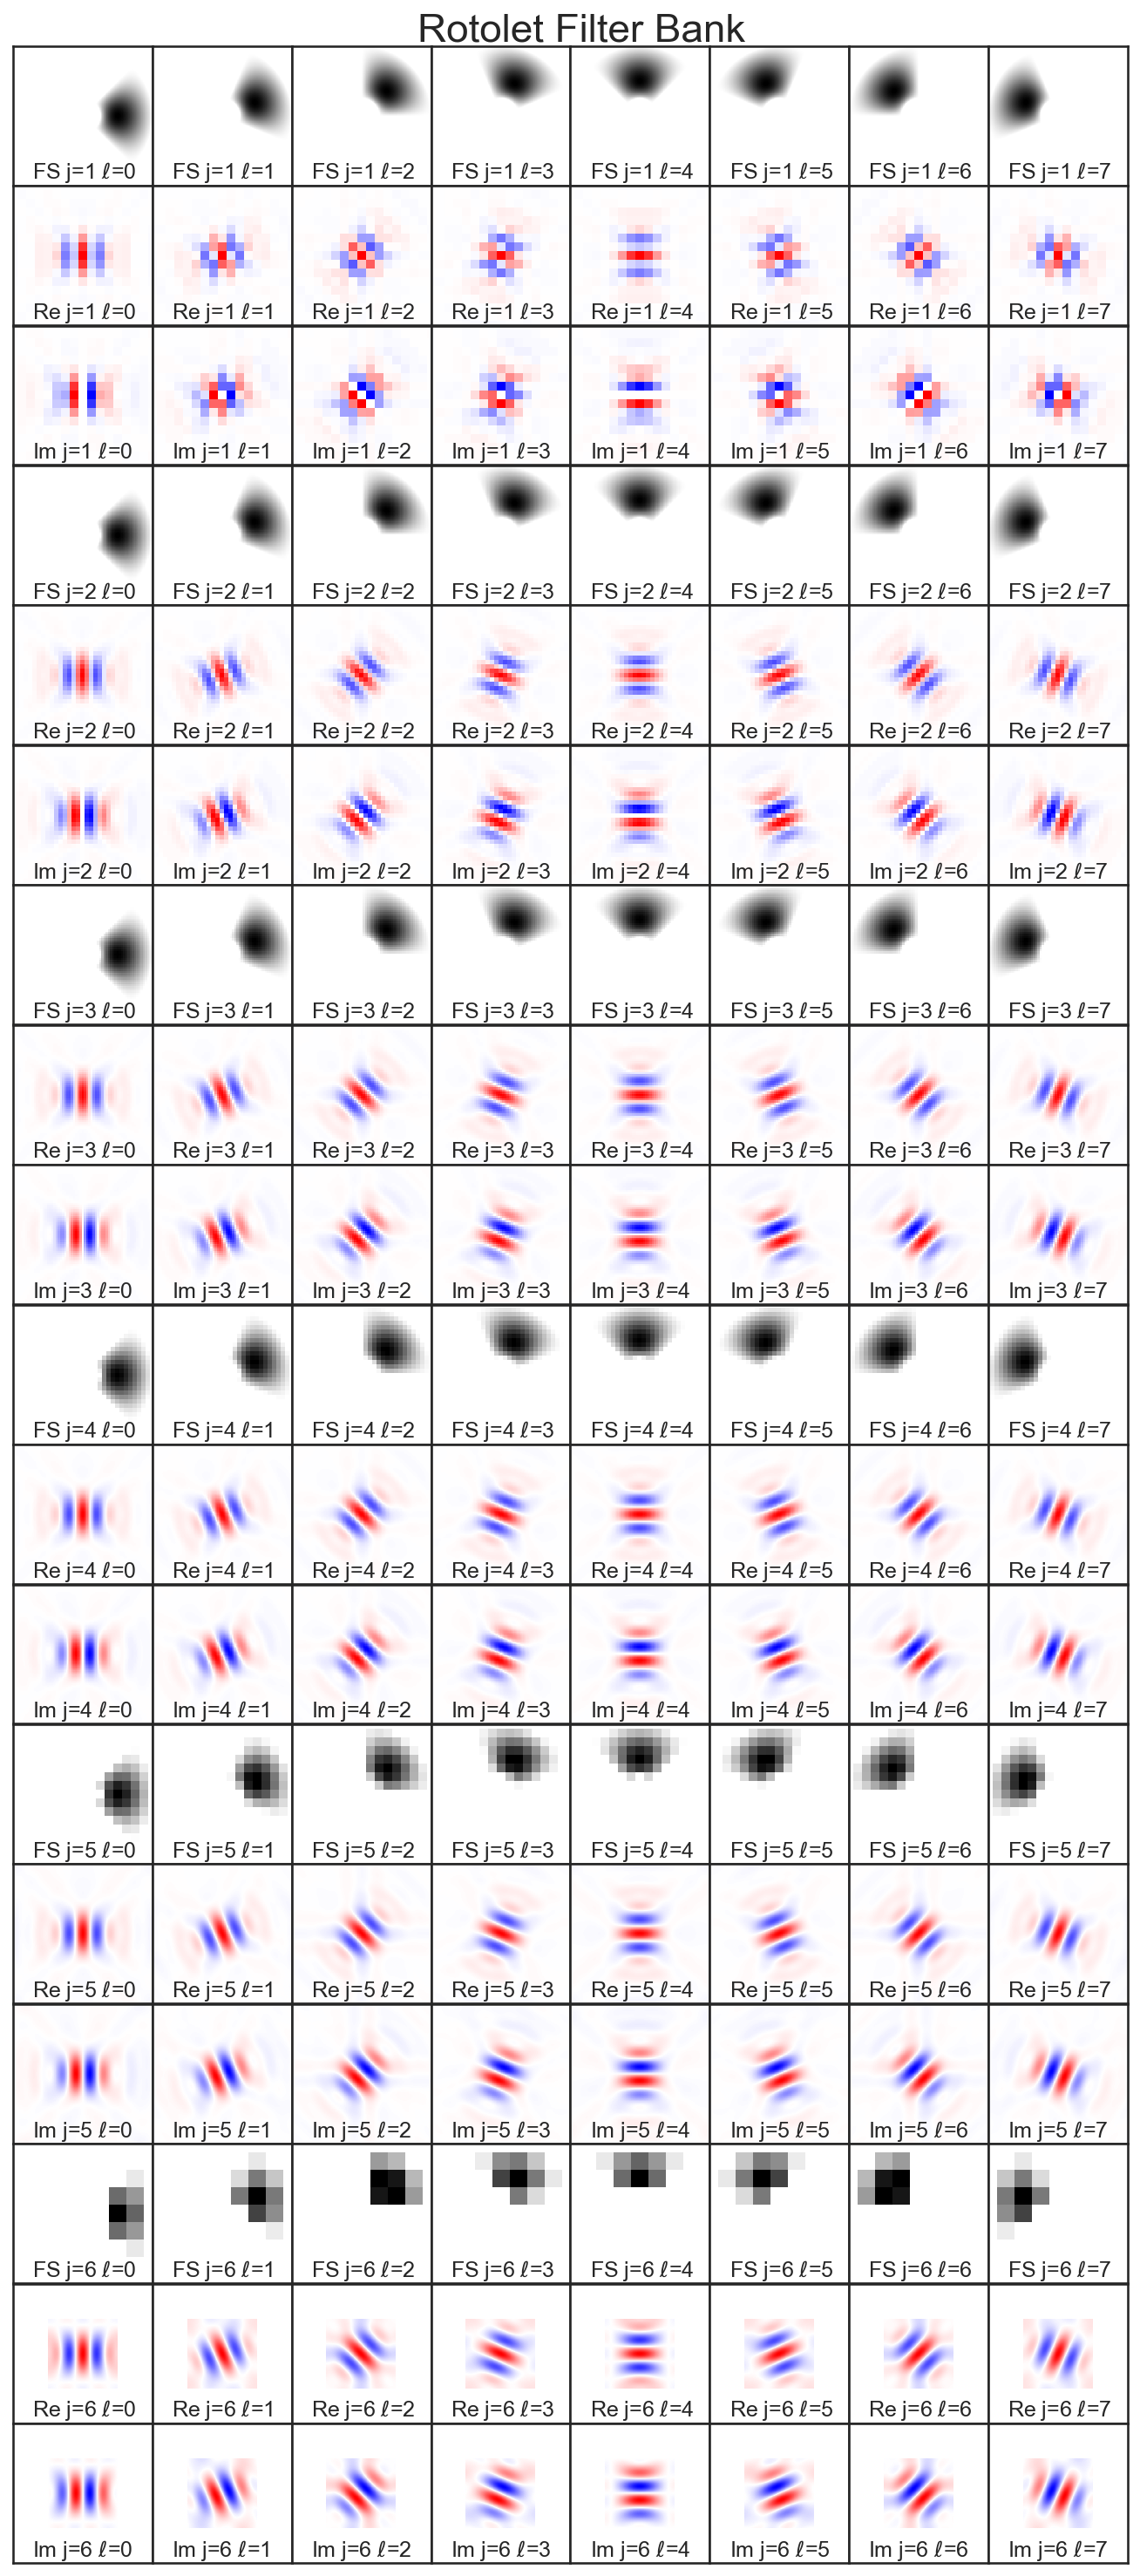

In [466]:
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(11,25.5), dpi=150)
for j in range(6):
    for l in range(8):
        data = filter_bank2D[filter_bank2D_psi_index[l,j]-1]
        subplotter(data,fig,6*3,8,j*8*3+l+1,j)

plt.suptitle('Rotolet Filter Bank',size=22,x=0.52,y=0.89)
fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('../figures/FinkletBank.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 3

In [265]:
rod_corner = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/coeffs')
rod_corner_lab = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/labels')

In [266]:
rod_corner_psi = hd5_open('../scratch_AKS/paper_data/corner_rod.h5','main/psi_index')

In [267]:
rod_corner.shape,rod_corner_lab.shape

((130321, 51), (130321, 3))

In [583]:
def angle_plots(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    indexes = indexes.astype(np.int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    ax.imshow(
        temp_mat.T,
        origin='lower',
        interpolation='nearest',
        cmap=colormaps[l],
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    ax.set_ylabel('$\Delta_\ell$')
    
    plt.vlines(l*180/8+90,0,361,'k','--',alpha=0.2)
    plt.vlines(l*180/8+180+90,0,361,'k','--',alpha=0.2)
    ax.set_xlim(0,361)
    return temp_mat[:,180]

In [611]:
rod_ex_images = hd5_open('../scratch_AKS/paper_data/images.h5','main/data')

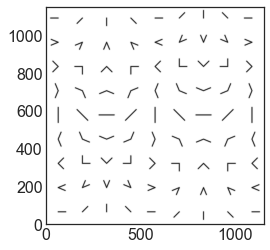

In [612]:
plt.imshow(rod_ex_images,origin='lower')

In [609]:
rod_ex_curves = hd5_open('../scratch_AKS/paper_data/curves.h5','main/data')

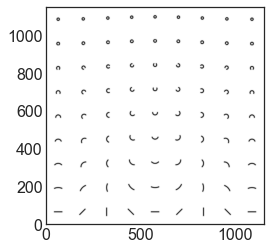

In [610]:
plt.imshow(rod_ex_curves,origin='lower')

In [398]:
import itertools

In [433]:
import sklearn

In [620]:
rod_curve = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/coeffs')
rod_curve_lab = hd5_open('../scratch_AKS/paper_data/curve_rod_40.h5','main/labels')

In [621]:
def curve_plots_strip(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    
    return temp_mat[:,indx]

In [622]:
def curve_plots_strip_n(fig,index_data, data, subplotx,subploty,subplotindx,l,indx):
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]
    row_sums = temp_mat.sum(axis=1)
    temp_mat2 = temp_mat / row_sums[:, np.newaxis]
    
    return temp_mat2[:,indx]

In [623]:
def curve_plots_n(fig,index_data, data, subplotx,subploty,subplotindx,l):
    ax = fig.add_subplot(subplotx,subploty,subplotindx)
    temp_mat = np.zeros((361,361))
    indexes = index_data
    list_angles = np.unique(indexes[:,1])
    indexes[:,1] = [np.where(list_angles==x)[0][0] for x in indexes[:,1]]
    indexes = indexes.astype(int)
    for index, ind in enumerate(indexes):
        temp_mat[ind[0],ind[1]] = data[index,4+l*6-1]

    row_sums = temp_mat.sum(axis=1)
    temp_mat2 = temp_mat / row_sums[:, np.newaxis]

    ax.imshow(
        temp_mat2.T,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=(0,0,0,0))
    plt.setp(ax.spines.values(), color=(0,0,0,0))
    ax.axes.xaxis.set_ticks([])
    #ax.axes.yaxis.set_ticks([])
    
    ax.set_yticks([0,90,180,270,360])
    ax.set_yticklabels((0,0.25,0.5,0.75,1.0))
    ax.set_ylabel('$f_{bend}$')
    
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    plt.vlines(l*180/8+90,0,361,'r','--',alpha=0)
    
    if l==0:
        plt.hlines(0,0,361,'r','--',alpha=0.5)
        plt.hlines(180,0,361,'g','--',alpha=0.5)
        plt.hlines(360,0,361,'b','--',alpha=0.5)
    ax.set_xlim(0,361)
        
    return ax

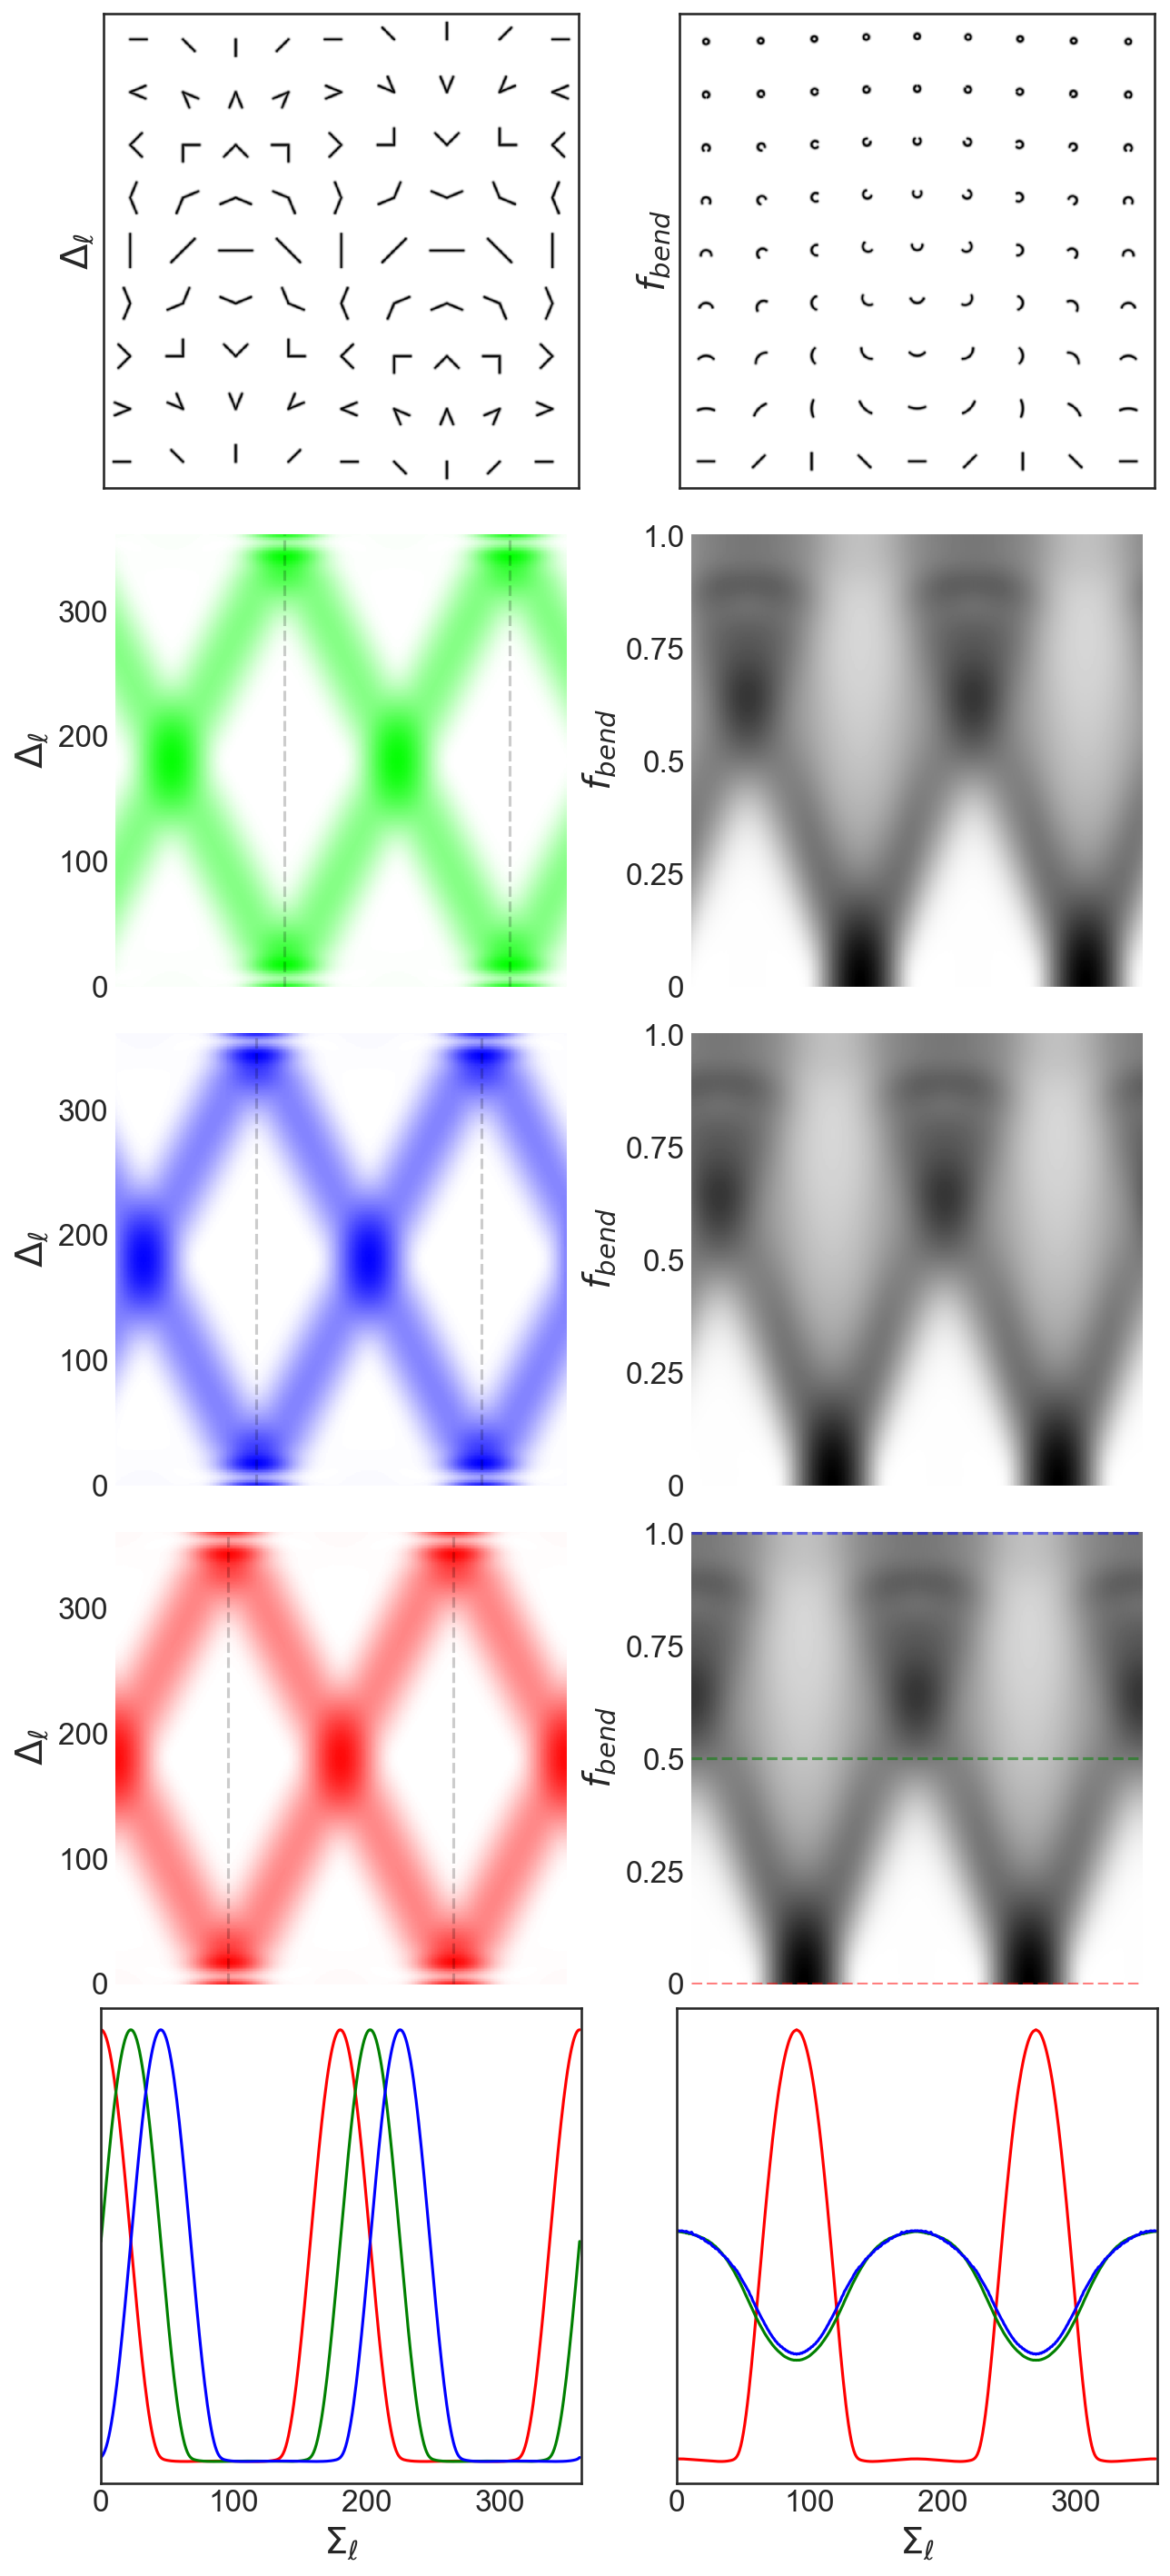

In [624]:
##
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta_\ell$')

series = np.zeros((3,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','g','b']
ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_xlabel('$\Sigma_\ell$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    ax1 = curve_plots_n(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l)

l=0
temp_ind = 0
for indx in [0,180,360]:
    series[temp_ind,:] = curve_plots_strip_n(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','g','b']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma_\ell$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)

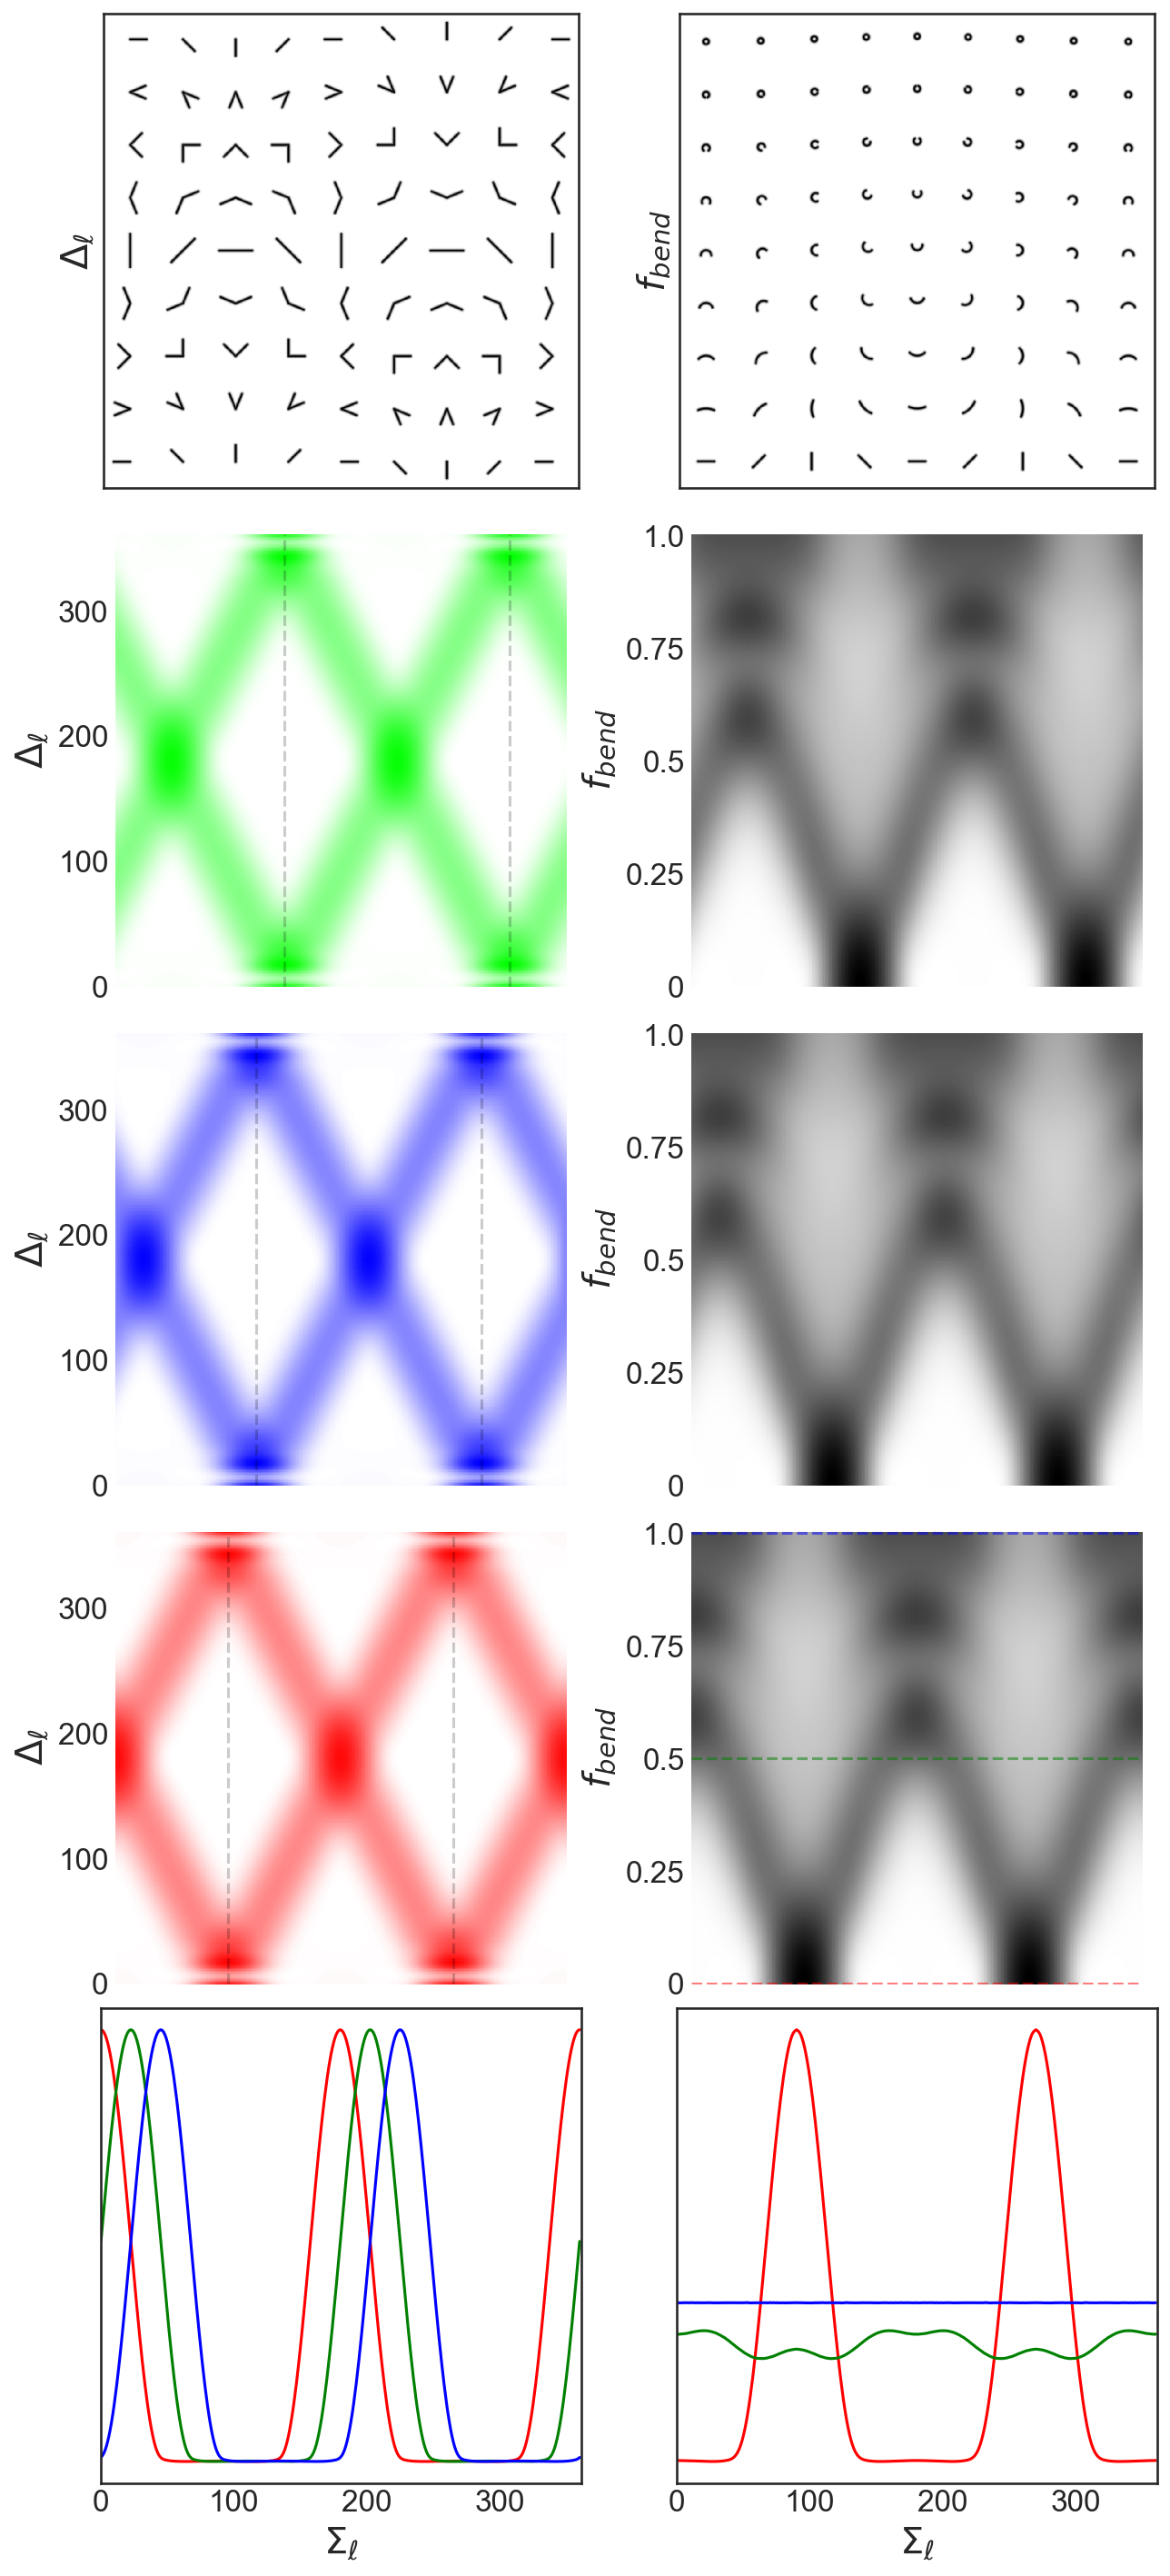

In [619]:
##
fig = plt.figure(figsize=(10,24), dpi=150)

ax = fig.add_subplot(5,2,1)
ax.imshow(
    rod_ex_images,
    #origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$\Delta_\ell$')

series = np.zeros((3,361))
for l in range(3):
    series[l,:] = angle_plots(fig,rod_corner_lab[:,0:2],rod_corner,5,2,2*(4-l)-1,l)

color_list = ['r','g','b']
ax = fig.add_subplot(5,2,9)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.set_xlabel('$\Sigma_\ell$')
ax.axes.yaxis.set_ticks([])

####

ax = fig.add_subplot(5,2,2)
ax.imshow(
    rod_ex_curves,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_ylabel('$f_{bend}$')

for l in range(3):
    ax1 = curve_plots_n(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l)

l=0
temp_ind = 0
for indx in [0,180,360]:
    series[temp_ind,:] = curve_plots_strip(fig,rod_curve_lab[:,0:2],rod_curve,5,2,2*(4-l),l,indx)
    temp_ind+=1

color_list = ['r','g','b']
ax = fig.add_subplot(5,2,10)
for i in range(0,3):
    ax.plot(series[i,:],color=color_list[i])
ax.set_xlim(0,361)
ax.axes.yaxis.set_ticks([])
ax.set_xlabel('$\Sigma_\ell$')

fig.subplots_adjust(hspace=0.05,wspace=0.2)
plt.savefig('../figures/RotEquiv.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

Figure 4

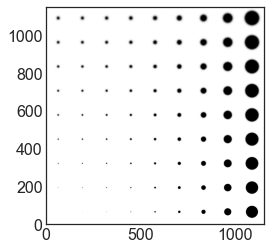

In [628]:
disc_ex_images = hd5_open('../scratch_AKS/paper_data/discs.h5','main/data')
plt.imshow(disc_ex_images,origin='lower')